# Import modules

In [546]:
import torch

In [547]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable

In [548]:
import pandas as pd

In [549]:
import numpy as np

In [777]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [551]:
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import sys

# LSTM model: airflight prediction

## Importing data

In [591]:
path = '/Users/olivierdebeyssac/Python_LSTM/airline-passengers.csv'
df = pd.read_csv(path, sep=',')

In [592]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [593]:
print('df["Month"] dtypes: {}'.format(df['Month'][0:2].dtype))
print('len df: {}'.format(len(df)))

df["Month"] dtypes: object
len df: 144


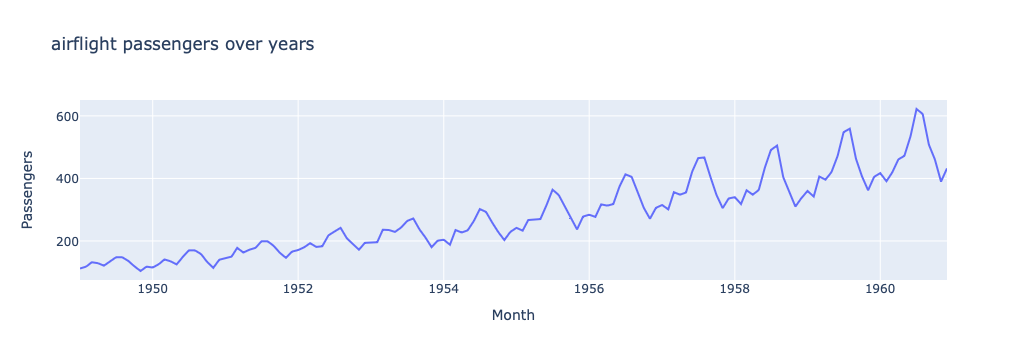

In [594]:
fig = px.line(df, x='Month', y='Passengers', title='airflight passengers over years')
fig.show()

In [595]:
df.isnull().mean()

Month         0.0
Passengers    0.0
dtype: float64

## Train set and test set

In [596]:
timeseries = df[['Passengers']].values.astype('float')
print('timeseries shape: {}'.format(timeseries.shape))

timeseries shape: (144, 1)


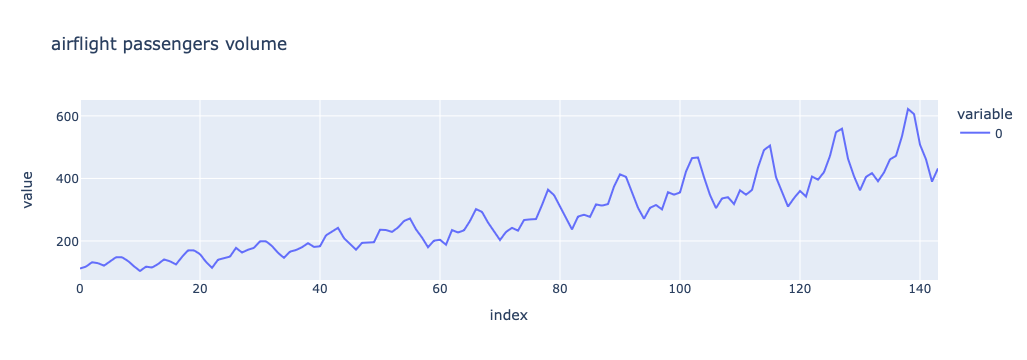

In [597]:
fig = px.line(timeseries, title='airflight passengers volume')
fig.show()

In [598]:
lenght = len(timeseries)
ratio = 0.70

lenght_train = int(lenght * ratio)
train = timeseries[0:lenght_train]
test = timeseries[lenght_train:]

print('train shape: {}'.format(train.shape))
print('test shape: {}'.format(test.shape))

train shape: (100, 1)
test shape: (44, 1)


# Standard scaler

In [599]:
scaler = StandardScaler()
timeseries = scaler.fit_transform(timeseries)
train = scaler.fit_transform(train)
test = scaler.transform(test)

# Window size

##### <font color='red'>LSTM model principle is that prediction at time "t" is a combination of input state at time "t" and input state at time "t - w" (called the window).
So, said that, we have to define window period<font>

In [600]:
seq_length = 6

In [601]:
def create_dataset(dataset, seq_length):
    'transform timeseries into prediction dataset'
    
    'arguments:'
    '1. dataset: numpy array which first dimension is time step'
    '2. lookbach: size of window to make predictions'

    X= []
    y = []
    for i in range(len(dataset) - seq_length - 1):
        feature = dataset[i: i + seq_length]
        target = dataset[i + seq_length]
        X.append(feature)
        y.append(target)
    
    #print(X)
    #print(y)
    print('len(X): {}'.format(len(X)))
    print('len(y): {}'.format(len(y)))
    X = np.asarray(X)
    y = np.asarray(y)
    print('X array.shape: {}'.format(X.shape))
    print('y array.shape: {}'.format(y.shape))

    
    return X, y

    
    

In [602]:
X_ts, y_ts = create_dataset(timeseries, seq_length)
print('X_ts.shape: {}, y_ts.shape: {}'.format(X_ts.shape, y_ts.shape))

len(X): 137
len(y): 137
X array.shape: (137, 6, 1)
y array.shape: (137, 1)
X_ts.shape: (137, 6, 1), y_ts.shape: (137, 1)


In [603]:
X_train, y_train = create_dataset(train, seq_length)
print('X_train.shape: {}, y_train.shape: {}'.format(X_train.shape, y_train.shape))

len(X): 93
len(y): 93
X array.shape: (93, 6, 1)
y array.shape: (93, 1)
X_train.shape: (93, 6, 1), y_train.shape: (93, 1)


In [652]:
X_test, y_test = create_dataset(test, seq_length)
print('X_test.shape: {}, y_test.shape: {}'.format(X_test.shape, y_test.shape))

len(X): 37
len(y): 37
X array.shape: (37, 6, 1)
y array.shape: (37, 1)
X_test.shape: (37, 6, 1), y_test.shape: (37, 1)


In [605]:
print('X_train.dtype: {}'.format(X_train.dtype))
print('y_train.dtype: {}'.format(y_train.dtype))
print()
print('X_test.dtype: {}'.format(X_test.dtype))
print('y_test.dtype: {}'.format(y_test.dtype))

X_train.dtype: float64
y_train.dtype: float64

X_test.dtype: float64
y_test.dtype: float64


# To tensor

In [606]:
X_ts = Variable(torch.Tensor(X_ts))
print('X_ts.shape: {}, X_ts.dtype: {}'.format(X_ts.shape, X_ts.dtype))

X_ts.shape: torch.Size([137, 6, 1]), X_ts.dtype: torch.float32


In [607]:
y_ts = Variable(torch.Tensor(y_ts))
print('y_ts.shape: {}, y_ts.dtype: {}'.format(y_ts.shape, y_ts.dtype))

y_ts.shape: torch.Size([137, 1]), y_ts.dtype: torch.float32


In [608]:
X_train = Variable(torch.Tensor(X_train))
print('X_train.shape: {}, X_train.dtype: {}'.format(X_train.shape, X_train.dtype))

X_train.shape: torch.Size([93, 6, 1]), X_train.dtype: torch.float32


In [609]:
y_train = Variable(torch.Tensor(y_train))
print('y_train.shape: {}, y_train.dtype: {}'.format(y_train.shape, y_train.dtype))

y_train.shape: torch.Size([93, 1]), y_train.dtype: torch.float32


In [610]:
X_test = Variable(torch.Tensor(X_test))
print('X_test.shape: {}, X_test.dtype: {}'.format(X_test.shape, X_test.dtype))

X_test.shape: torch.Size([37, 6, 1]), X_test.dtype: torch.float32


In [611]:
y_test = Variable(torch.Tensor(y_test))
print('y_test.shape: {}, y_test.dtype: {}'.format(y_test.shape, y_test.dtype))

y_test.shape: torch.Size([37, 1]), y_test.dtype: torch.float32


# LSTM model

##### <font color='blue'>input_size: nb of features<font>


In [612]:
input_size = 1
hidden_size_1 = 64
hidden_size_2 = 32

n_epochs = 400
counter = 0
best_loss = 100
bool = True

In [613]:
class lstm_airflight(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm_1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size_1, num_layers=1, batch_first=True)
        self.dropout_1 = nn.Dropout(0.2)

        self.lstm_2 = nn.LSTM(input_size=hidden_size_1, hidden_size=hidden_size_2, num_layers=1, batch_first=True)
        self.dropout_2 = nn.Dropout(0.2)
        

        self.flat = nn.Flatten()
        
        # Linear layer expects dimensions to be batch, hidden_size
        in_features = hidden_size_2 * seq_length
        out_features = 16
        
        self.linear_1 = nn.Linear(in_features=in_features, out_features=out_features)
        self.dropout_linear_1 = nn.Dropout(0.2)
        self.relu_1 = nn.ReLU()

        in_features = out_features
        out_features = 8
        
        self.linear_2 = nn.Linear(in_features=in_features, out_features=out_features)
        self.dropout_linear_2 = nn.Dropout(0.2)
        self.relu_2 = nn.ReLU()

        in_features = out_features
        out_features = 1
        
        self.linear_3 = nn.Linear(in_features=in_features, out_features=out_features)


    

    def forward(self, x):
        x, notused = self.lstm_1(x)
        #print('lstm_1_output shape: {}, lstm_1_notused shape: {}'.format(x.shape, len(notused)))
        x = self.dropout_1(x)
        
        x, _ = self.lstm_2(x)
        #print('lstm_2_output shape: {}, lstm_2_notused shape: {}'.format(x.shape, len(notused)))
        x = self.dropout_2(x)
        

        x = x.unsqueeze(0)
        x = self.flat(x)
        
        x = self.linear_1(x)
        #print('linear_1_output shape: {}'.format(x.shape))
        
        x = self.dropout_linear_1(x)
        x = self.relu_1(x)

        x = self.linear_2(x)
        #print('linear_2_output shape: {}'.format(x.shape))

        x = self.dropout_linear_2(x)
        x = self.relu_2(x)
        #print('ReLU_2_output shape: {}'.format(x.shape))

        x = self.linear_3(x)
        #print('linear_3_output shape: {}'.format(x.shape))
        #print('linear_3_output: {}'.format(x))
        
        
        return x
    

In [614]:
model = lstm_airflight()
print(model)

lstm_airflight(
  (lstm_1): LSTM(1, 64, batch_first=True)
  (dropout_1): Dropout(p=0.2, inplace=False)
  (lstm_2): LSTM(64, 32, batch_first=True)
  (dropout_2): Dropout(p=0.2, inplace=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=192, out_features=16, bias=True)
  (dropout_linear_1): Dropout(p=0.2, inplace=False)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=16, out_features=8, bias=True)
  (dropout_linear_2): Dropout(p=0.2, inplace=False)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=8, out_features=1, bias=True)
)


## Loss function & optimizer

In [615]:
optimizer = Adam(model.parameters())

In [616]:
loss_fn = nn.MSELoss()

## Training

In [617]:
class early_stop():
    def __init__(self, epoch, dico, path, bool):
        self.epoch = epoch
        self.dico = dico
        self.path = path
        self.bool = bool

    def compute_loss(self):
        global counter
        global best_loss
        global bool
        #counter = 0
        #best_loss = self.dico[self.epoch]
        #print('best_loss: {}'.format(best_loss))

        if self.epoch > 0:
                
            if self.dico[self.epoch] < self.dico[self.epoch - 1]:
                best_loss = self.dico[self.epoch]
                torch.save(model.state_dict(), self.path)
                counter = 0
                print('==============')
                print('epoch n°: {}'.format(epoch))
                print('self.dico[self.epoch]: {} < self.dico[self.epoch - 1]: {}'.format(self.dico[self.epoch], self.dico[self.epoch - 1]))
                print('counter: {}'.format(counter))
                print('==============')
                print()

            if self.dico[self.epoch] >= self.dico[self.epoch - 1]:
                counter = counter + 1
                print('==============')
                print('epoch n°: {}'.format(epoch))
                print('self.dico[self.epoch]: {} >= self.dico[self.epoch - 1]: {}'.format(self.dico[self.epoch], self.dico[self.epoch - 1]))
                print('counter: {}'.format(counter))
                print('==============')
                print()

            if counter > 0:
                if self.dico[self.epoch] < self.dico[self.epoch - 1]:
                    if self.dico[self.epoch] < best_loss:
                        counter = 0
                        best_loss = self.dico[self.epoch]
                        torch.save(model.state_dict(), self.path)
                        print('==============')
                        print('epoch n°: {}'.format(epoch))
                        print('Counter > 0, self.dico[self.epoch]: {} < self.dico[self.epoch - 1]: {}, best_loss: {}'.format(self.dico[self.epoch], self.dico[self.epoch - 1], best_loss))
                        print('counter: {}'.format(counter))
                        print('==============')
                        print()

                    if self.dico[self.epoch] >= best_loss:
                        counter = counter + 1
                        print('==============')
                        print('epoch n°: {}'.format(epoch))
                        print('Counter > 0, self.dico[self.epoch]: {} >= self.dico[self.epoch - 1]: {}, best_loss: {}'.format(self.dico[self.epoch], self.dico[self.epoch - 1], best_loss))
                        print('counter: {}'.format(counter))
                        print('==============')
                        print()
                        

            
            if counter > 5:
                print('fin sur epoch n°: {}'.format(epoch))
                self.bool = False
            
        return self.bool               
                

In [618]:
l_train = []
l_test = []
d_train = {}
d_test = {}

nb_loop = 0

l_y = []
l_y_pred = []

l_mean_y = []
l_mean_y_pred = []

path = '/Users/olivierdebeyssac/Python_LSTM/best_model.pt'

for epoch in range(n_epochs):
    model.train()
    for X, y in zip(X_train, y_train):
        nb_loop = nb_loop + 1
        y_pred = model(X)

        if nb_loop < 2:
            #print('nb_loop: {}'.format(nb_loop))
            y = np.reshape(y, (1, 1))


            print('===========')
            print('nb_loop: {}'.format(nb_loop))
            print('X.shape: {}'.format(X.shape))        
            print('y_pred.shape: {}, y: {}'.format(y_pred.shape, y.shape))
            print('===========')
        
        loss_train = loss_fn (y_pred, y)
        l_train.append(loss_train.detach().numpy())
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
    d_train[epoch] = np.mean(l_train)
    


    # Pour chaque batch on save la valeur moyenne de l'erreur dans une liste.
    # En fin d'epoch, on a stocké toutes les valeurs de loss correspondantes aux batchs.
    # On va donc pouvoir comparer des valeurs moyennes entre elles.
    # Si un modèle fonctionne bien, ca veut dire qu'il produit des erreurs relativement faibles
    # quelque soit le batch, et un modèle qui fonctionne moins bien aura quelques valeurs d'ereur
    # plus élevées et donc une moyenne lègèrement plus élévée.
    # Il est tout à fait possible que dans ce modèle qui fonctionne un peu moins bien, on ait
    # une valeur d'erreur très faible pour un batch donné.
    # Si on avait choisi de sélectionner le modèle sur la base d'un valeur min() plutôt que sur
    # la base d'une valeur moyenne on aurait alors choisi ce modèle qui fonctionne un peu moins bien...
    # Il vaut donc mieux travailler avec un critère de moyenne plutôt qu'avec un critère de valeur min()

    
    model.eval()
    for X, y in zip(X_test, y_test):
        with torch.no_grad():

            y_pred = model(X)
            y = np.reshape(y, (1,1))
            loss_test = loss_fn(y_pred, y)
            l_test.append(loss_test.numpy())

            l_y.append(y)
            l_y_pred.append(y_pred)

                
    mean_y = np.mean(l_y)
    mean_y_pred = np.mean(l_y_pred)
    l_mean_y.append(mean_y)
    l_mean_y_pred.append(mean_y_pred)

#    if epoch < 3:
#       print(len(l_mean_y))
#       print(len(l_mean_y_pred))
    
    
    
    d_test[epoch] = np.mean(l_test)
    es = early_stop(epoch, d_test, path, bool)
    var_bool = es.compute_loss()
    print('epoch: {}, var_bool: {}'.format(epoch, var_bool))
    
    if var_bool == False:
        break
    

    

nb_loop: 1
X.shape: torch.Size([6, 1])
y_pred.shape: torch.Size([1, 1]), y: torch.Size([1, 1])
epoch: 0, var_bool: True


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



epoch n°: 1
self.dico[self.epoch]: 6.923555850982666 < self.dico[self.epoch - 1]: 10.10731315612793
counter: 0

epoch: 1, var_bool: True
epoch n°: 2
self.dico[self.epoch]: 6.072753429412842 < self.dico[self.epoch - 1]: 6.923555850982666
counter: 0

epoch: 2, var_bool: True
epoch n°: 3
self.dico[self.epoch]: 5.637229919433594 < self.dico[self.epoch - 1]: 6.072753429412842
counter: 0

epoch: 3, var_bool: True
epoch n°: 4
self.dico[self.epoch]: 5.392576217651367 < self.dico[self.epoch - 1]: 5.637229919433594
counter: 0

epoch: 4, var_bool: True
epoch n°: 5
self.dico[self.epoch]: 5.264624118804932 < self.dico[self.epoch - 1]: 5.392576217651367
counter: 0

epoch: 5, var_bool: True
epoch n°: 6
self.dico[self.epoch]: 5.16831636428833 < self.dico[self.epoch - 1]: 5.264624118804932
counter: 0

epoch: 6, var_bool: True
epoch n°: 7
self.dico[self.epoch]: 4.997067451477051 < self.dico[self.epoch - 1]: 5.16831636428833
counter: 0

epoch: 7, var_bool: True
epoch n°: 8
self.dico[self.epoch]: 4.827332

## Loss visualization

In [619]:
df_loss_train = pd.DataFrame(d_train, columns=range(len(d_train)), index=[0])
df_loss_train = df_loss_train.T
df_loss_train = df_loss_train.rename(columns={0: 'loss_tr'})

df_loss_test = pd.DataFrame(d_test, columns=range(len(d_test)), index=[0])
df_loss_test = df_loss_test.T
df_loss_test = df_loss_test.rename(columns={0: 'loss_t'})


In [620]:
df_loss = pd.concat([df_loss_train, df_loss_test], axis=1)
df_loss.head()

,loss_tr,loss_t
0,1.056164,10.107313
1,0.872100,6.923556
2,0.854765,6.072753
3,0.809744,5.637230
4,0.782755,5.392576


In [621]:
min_loss = df_loss['loss_tr'].min()
idx_loss = df_loss[df_loss['loss_tr'] == min_loss].index
print('min_loss: {}, epoch: {}'.format(min_loss, idx_loss))

min_loss: 0.1866951286792755, epoch: Index([195], dtype='int64')


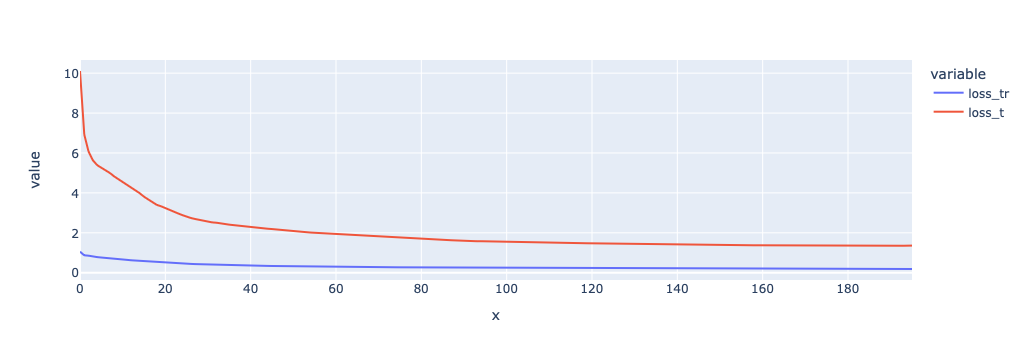

In [622]:
fig = px.line(df_loss, x=df_loss_train.index, y=['loss_tr', 'loss_t'])
fig.show()

In [623]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [765]:
l_pred = []
l_actuals = []
for epoch in range(1):
    model.eval()
    with torch.no_grad():
        for X, y in zip(X_ts[lenght_train:,:,:], y_ts[lenght_train:, :]):
            y_pred = model(X)
            y_pred = y_pred[0]
            #print('y_pred: {}'.format(y_pred.shape))
            l_pred.append(y_pred.detach().numpy())
            #l_actuals.append(y)
preds = np.asarray(l_pred)
actuals = y_ts.numpy()

print(preds.shape, actuals.shape)

(37, 1) (137, 1)


# Preds visualization

In [766]:
df_actuals = pd.DataFrame(scaler.inverse_transform(actuals), columns=['actuals'])
#print(df_actuals[0:5])

df_preds = pd.DataFrame(scaler.inverse_transform(preds), columns=['preds'], index=range(lenght_train, len(y_ts)))
#print(df_preds[0:5])

#df_preds['shifted'] = df_preds['preds'].shift(seq_length - 1, axis=0)

print('df_actuals: {}'.format(df_actuals.shape))
print('df_preds: {}'.format(df_preds.shape))

#print('df_actuals {}'.format(df_actuals))
#print('df_preds {}'.format(df_preds))


x1 = df_actuals.index
x2 = df_preds.index

print(x1)
print(x2)

y1 = df_actuals['actuals'].values
y2 = df_preds['preds'].values

print('y2.shape: {}'.format(y2.shape))


df_actuals: (137, 1)
df_preds: (37, 1)
RangeIndex(start=0, stop=137, step=1)
RangeIndex(start=100, stop=137, step=1)
y2.shape: (37,)


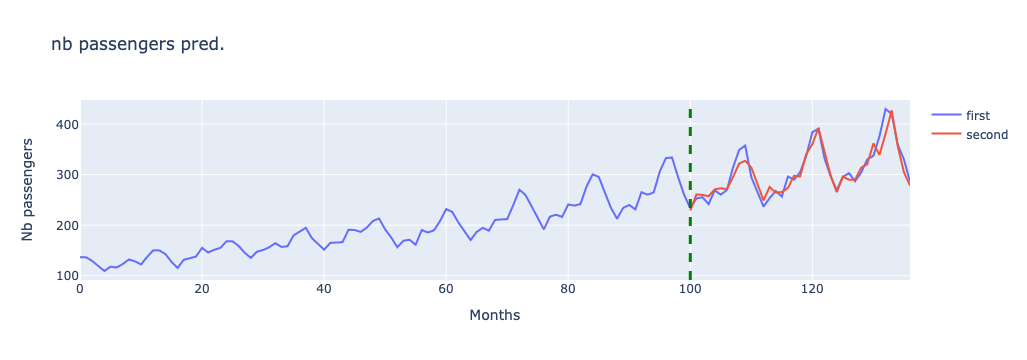

In [767]:
f1 = go.Figure(
    data = [
        go.Scatter(x=x1, y=y1, name="first"),
        go.Scatter(x=x2, y=y2, name="second"),
    ],
    layout = {"xaxis": {"title": "Months"}, "yaxis": {"title": "Nb passengers"}, "title": "nb passengers pred."}
)
f1.add_vline(x=lenght_train, line_width=3, line_dash="dash", line_color="green")
f1.show()


# Preds metrics

In [768]:
actuals = y_ts[lenght_train:, :].numpy()
actuals = scaler.inverse_transform(actuals)
preds = scaler.inverse_transform(preds)

In [769]:
print('actuals.shape: {}'.format(actuals.shape))
print('preds.shape: {}'.format(preds.shape))

actuals.shape: (37, 1)
preds.shape: (37, 1)


In [780]:
mse = mean_squared_error(actuals, preds)
mae = mean_absolute_error(actuals, preds)
mae_percent = mean_absolute_percentage_error(actuals, preds)
print('mse: {}, mae: {}'.format(mse, mae, np.round((mae/np.sum(actuals)), 3)))
print('error in %: {}'.format(mae_percent))


mse: 288.3475036621094, mae: 12.95665454864502
error in %: 0.040980786085128784


In [ ]:
input_size = 1
hidden_size_1 = 128
hidden_size = 64

In [ ]:
lstm_1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size_1, num_layers=1, batch_first=True)
lstm_2 = nn.LSTM(input_size=hidden_size_1, hidden_size=hidden_size_2, num_layers=1, batch_first=True)
flat = nn.Flatten()

X_train = torch.randn(95, 4, 1)
x = X_train[0]#.unsqueeze(0)

print(x.shape)
# torch.Size([4, 1])
out, _ = lstm_1(x)
print(out.shape)
# torch.Size([4, 128])
out, _ = lstm_2(out)
print(out.shape)
# torch.Size([4, 64])
out = flat(out)
print(out.shape)
# torch.Size([4, 64])

In [ ]:
lstm_1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size_1, num_layers=1, batch_first=True)
lstm_2 = nn.LSTM(input_size=hidden_size_1, hidden_size=hidden_size_2, num_layers=1, batch_first=True)
flat = nn.Flatten()

X_train = torch.randn(95, 4, 1)
x = X_train[0].unsqueeze(0)

print(x.shape)
# torch.Size([4, 1])
out, _ = lstm_1(x)
print(out.shape)
# torch.Size([4, 128])
out, _ = lstm_2(out)
print(out.shape)
# torch.Size([4, 64])
out = flat(out)
print(out.shape)
# torch.Size([4, 64])

In [ ]:
a = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]])
a

b = torch.tensor(a)
print(b.shape)

In [ ]:
b = b.unsqueeze(0)
print(b.shape)

In [ ]:
b = flat(b)
b
print(b.shape)

In [ ]:
for param in model.parameters():
    print(type(param), param.size())

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(X_train)
    print(X_train.shape)
    print(y_train.shape)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, y_train)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

In [ ]:
lstm.eval()
train_predict = lstm(X_ts)

data_predict = train_predict.data.numpy()
dataY_plot = y_ts.data.numpy()
print(data_predict)
#print(dataY_plot)

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.axvline(x=lenght_train, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [ ]:
seq_length = 4
hidden_size_1 = 128
hidden_size_2 = 64

In [ ]:
X_train = torch.randn([100, 4, 1])
X_train = X_train[0]
print(X_train)
print(X_train.shape)
x = torch.unsqueeze(X_train, 0)
print(x)
print(x.shape)

In [ ]:

lstm_1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size_1, num_layers=1, batch_first=True)
dropout_1 = nn.Dropout(0.2)
lstm_2 = nn.LSTM(input_size=hidden_size_1, hidden_size=hidden_size_2, num_layers=1, batch_first=True)

flat = nn.Flatten()
        
# Linear layer expects dimensions to be batch, hidden_size
in_features = hidden_size_2 * seq_length
out_features = 32
        
linear_1 = nn.Linear(in_features=in_features, out_features=out_features)
dropout_2 = nn.Dropout(0.2)
relu_1 = nn.ReLU()

in_features = out_features
out_features = 16
        
linear_2 = nn.Linear(in_features=in_features, out_features=out_features)
dropout_3 = nn.Dropout(0.2)
relu_2 = nn.ReLU()

in_features = out_features
out_features = 1
        
linear_3 = nn.Linear(in_features=in_features, out_features=out_features)


out, _ = lstm_1(x)
print('ouput lstm_1.shape: {}'.format(out.shape))
out, _ = lstm_2(out)
print('ouput lstm_2.shape: {}'.format(out.shape))
out = flat(out)
print('out flat: {}'.format(out.shape))
out = linear_1(out)
print('ouput linear_1.shape: {}'.format(out.shape))
